# Predict the probability of stroke happening to the patients

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

import scipy.stats
import math

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE

In [642]:
train_data = pd.read_csv("/Users/divyavakil/Documents/train-file.csv")
test_data = pd.read_csv("/Users/divyavakil/Documents/test-file.csv")

In [643]:
train_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [644]:
test_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [645]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [646]:
# Checking null values for BMI and Smoking Status
len(train_data[train_data.bmi.isnull()]), len(train_data[train_data.smoking_status.isnull()])

(1462, 13292)

In [647]:
# Checking null values for BMI when stroke
len(train_data[train_data.bmi.isnull() & train_data.stroke == 1])

140

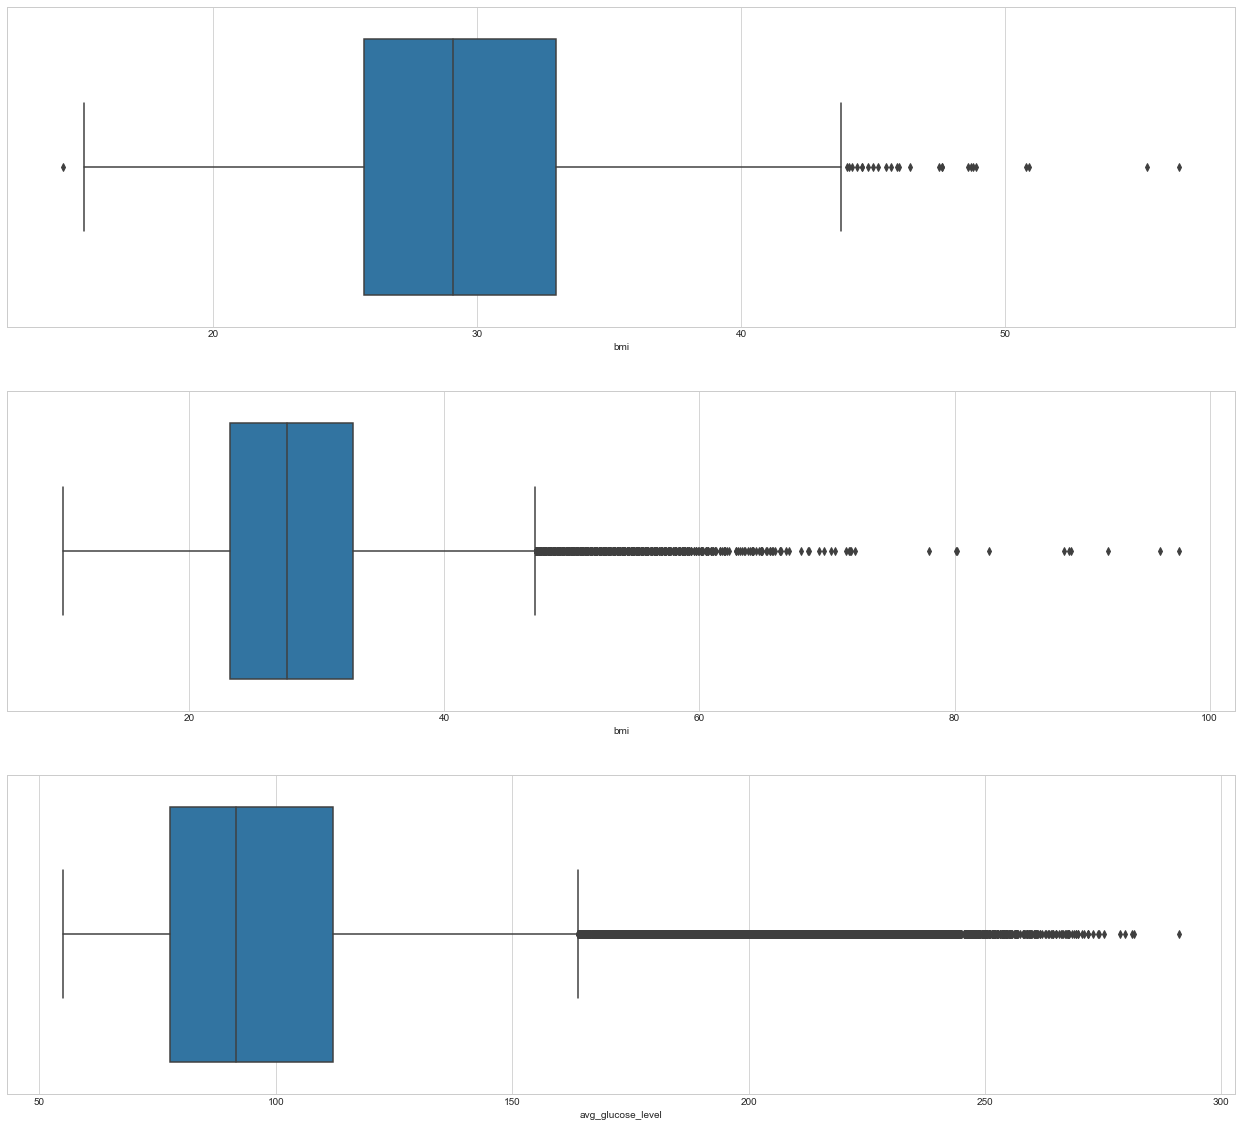

In [648]:
# Outlier Detection

fig, axs = plt.subplots(3, figsize = (22,20), clear = True)

sns.boxplot(train_data[(train_data.stroke == 1)].bmi, ax = axs[0])
sns.boxplot(train_data[(train_data.stroke == 0)].bmi, ax = axs[1])
sns.boxplot(train_data.avg_glucose_level, ax = axs[2])

In [669]:
train = train_data.copy()

# Filter values that has BMI == NULL for stroke 0
train = train[((~train.bmi.isnull()) & (train.stroke == 0)) | (train.stroke == 1)]  

# Fill remaining NULL values with median
train.bmi.fillna(train.bmi.median(), inplace = True)


# Other Attempts
#train = train[train.bmi < 60]
#train = train[train.avg_glucose_level < 250]
#train.bmi.fillna(0, inplace = True)
#train.bmi.fillna(train_data['bmi'][(train_data.stroke == 1)].median(), inplace = True)
#train.smoking_status.fillna(train.smoking_status.median(), inplace = True)

In [670]:
# Convert to Categorical variables
train.hypertension = train.hypertension.astype('category')
train.heart_disease = train.heart_disease.astype('category')
train.stroke = train.stroke.astype('category')

In [671]:
# Normalization of positively skewed variables
train['log_bmi'] = np.log10(train.bmi)
train['log_avg_glucose_level'] = np.log10(train.avg_glucose_level)

# BoxCox failed to normalize it well
#train['log_bmi'] = scipy.stats.boxcox(train.bmi, lmbda=None)[0]
#train['log_avg_glucose_level'] = scipy.stats.boxcox(train.avg_glucose_level, lmbda=None)[0]

In [672]:
# Sub-Sampling to handle imbalance data
train = train[train.stroke == 0].sample(len(train[train.stroke == 1])*20).append(train[train.stroke == 1])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 28475 to 43339
Data columns (total 14 columns):
id                       16443 non-null int64
gender                   16443 non-null object
age                      16443 non-null float64
hypertension             16443 non-null category
heart_disease            16443 non-null category
ever_married             16443 non-null object
work_type                16443 non-null object
Residence_type           16443 non-null object
avg_glucose_level        16443 non-null float64
bmi                      16443 non-null float64
smoking_status           11498 non-null object
stroke                   16443 non-null category
log_bmi                  16443 non-null float64
log_avg_glucose_level    16443 non-null float64
dtypes: category(3), float64(5), int64(1), object(5)
memory usage: 1.6+ MB


In [673]:
# Preparing Train-Test Data
X = train.copy()
X.pop('stroke')
y = train[['stroke']]
X.head()
y.head()

,stroke
28475,0
41419,0
30833,0
1760,0
39410,0


In [674]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

In [675]:
# Information about Train Test Splits
X_train.info()
X_test.info()
y_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11510 entries, 11368 to 39595
Data columns (total 13 columns):
id                       11510 non-null int64
gender                   11510 non-null object
age                      11510 non-null float64
hypertension             11510 non-null category
heart_disease            11510 non-null category
ever_married             11510 non-null object
work_type                11510 non-null object
Residence_type           11510 non-null object
avg_glucose_level        11510 non-null float64
bmi                      11510 non-null float64
smoking_status           8034 non-null object
log_bmi                  11510 non-null float64
log_avg_glucose_level    11510 non-null float64
dtypes: category(2), float64(5), int64(1), object(5)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4933 entries, 26869 to 41467
Data columns (total 13 columns):
id                       4933 non-null int64
gender                   4933 non-nul

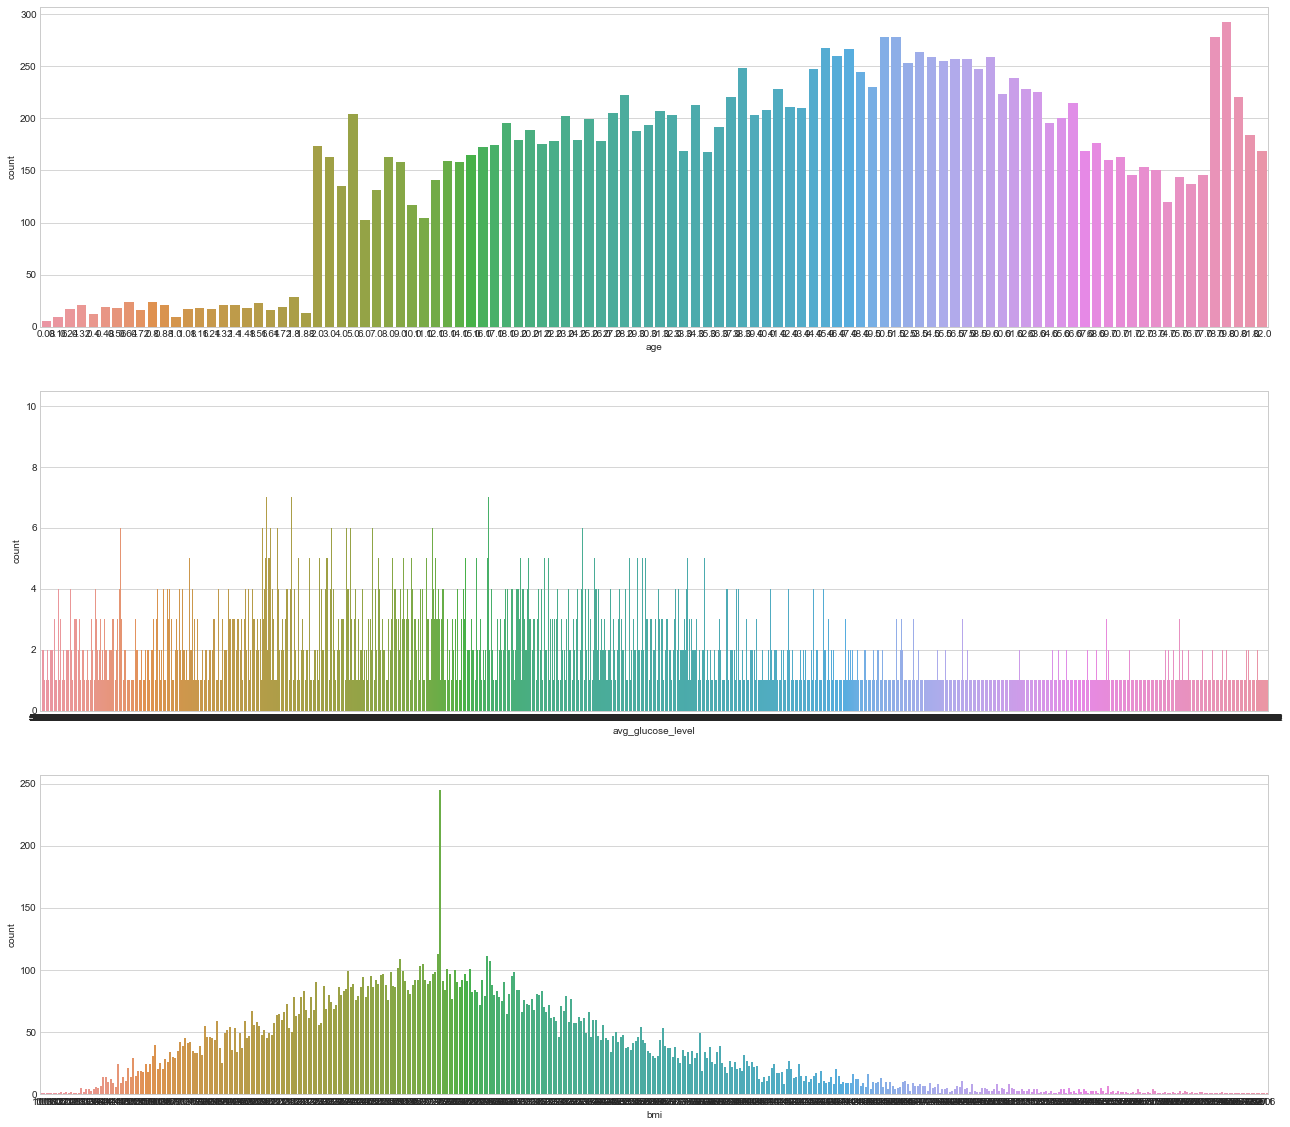

In [676]:
# Univariate Analysis - Numerical Variables

fig, axs = plt.subplots(3, figsize = (22,20), clear = True)

ax = sns.countplot(x="age", data=train, ax = axs[0])
ax = sns.countplot(x="avg_glucose_level", data=train, ax = axs[1])
ax = sns.countplot(x="bmi", data=train, ax = axs[2])

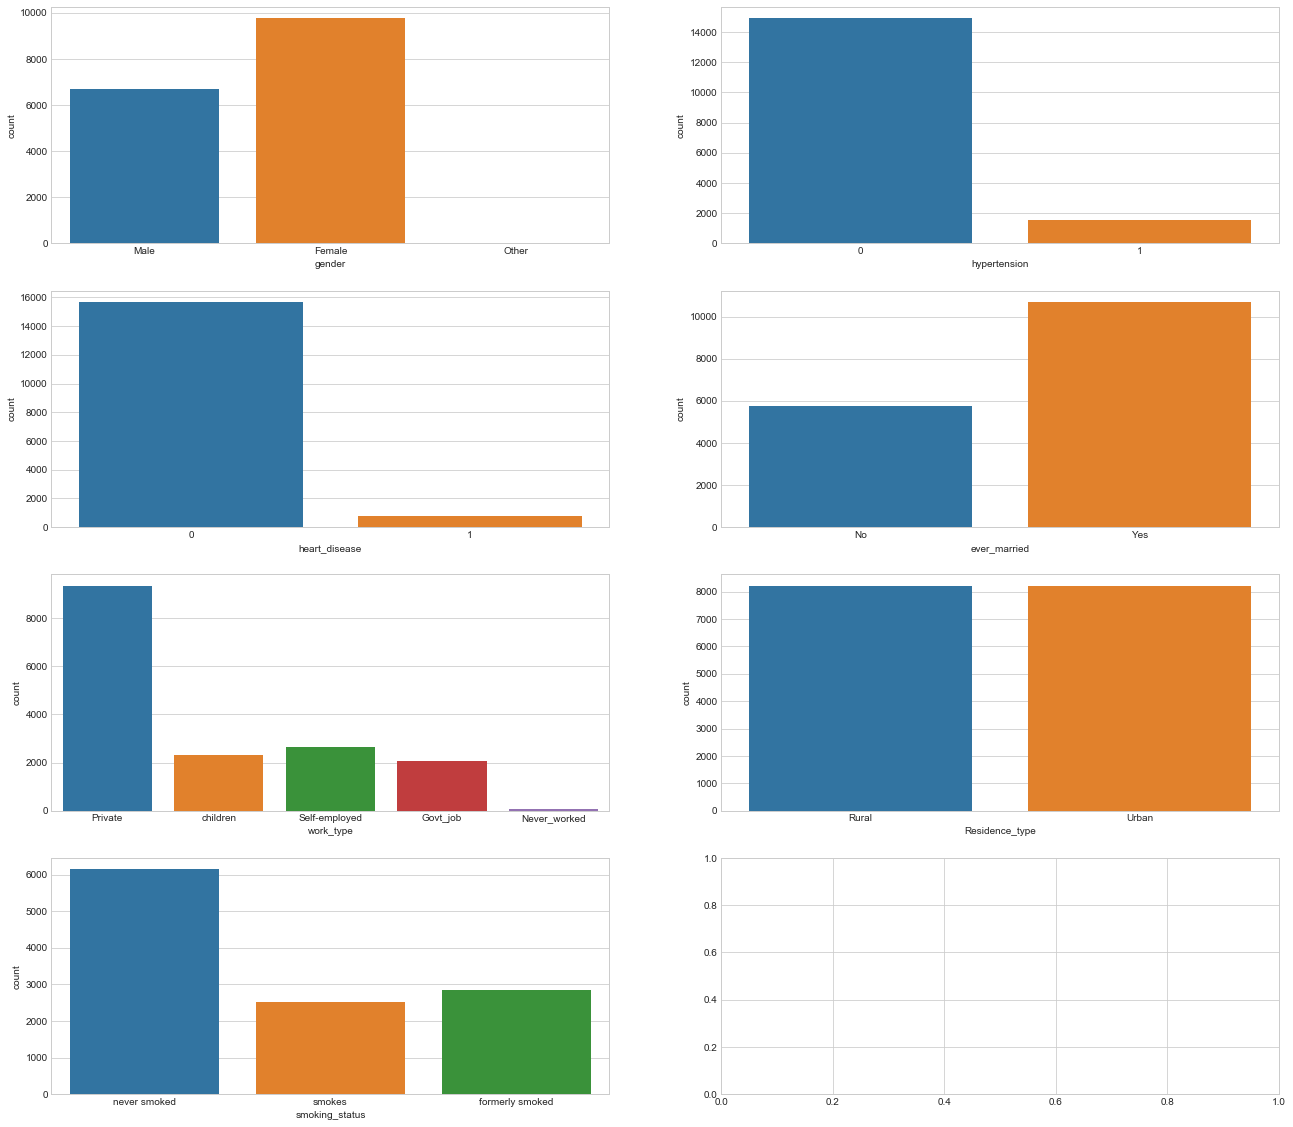

In [677]:
# Univariate Analysis - Categorical / Binary Variables
fig, axs = plt.subplots(4, 2, figsize = (22,20), clear = True)
X_train.gender.unique()

sns.set_style('whitegrid')

ax = sns.countplot(x="gender", data=train,ax=axs[0,0])
ax = sns.countplot(x="hypertension", data=train, ax=axs[0,1])
ax = sns.countplot(x="heart_disease", data=train, ax=axs[1,0])
ax = sns.countplot(x="ever_married", data=train, ax=axs[1,1])
ax = sns.countplot(x="work_type", data=train, ax=axs[2,0])
ax = sns.countplot(x="Residence_type", data=train, ax=axs[2,1])
ax = sns.countplot(x="smoking_status", data=train, ax=axs[3,0])

In [678]:
# Used Chi-Square Test for Bivariate Analysis for Categorical Variables
def pvalue_chisq(col1,col2):
    result = scipy.stats.chi2_contingency(pd.crosstab(col1,col2))
    return result[1]

In [679]:
# Categorical Variables - Test of Indenpedence (Chi-Square Test)
cat_var = ["stroke", "smoking_status", "Residence_type", "work_type", "ever_married", "heart_disease", "hypertension", "gender"]

for i in range(len(cat_var)):
    for j in range(i+1,len(cat_var)):
        print(cat_var[i]," * ", cat_var[j], " = ", pvalue_chisq(train[cat_var[i]],train[cat_var[j]]))

stroke  *  smoking_status  =  7.84651417229e-09
stroke  *  Residence_type  =  0.614292528177
stroke  *  work_type  =  3.65162389662e-52
stroke  *  ever_married  =  1.08817941972e-49
stroke  *  heart_disease  =  1.6765906819e-131
stroke  *  hypertension  =  2.87992550531e-56
stroke  *  gender  =  0.0411902527701
smoking_status  *  Residence_type  =  0.765277410333
smoking_status  *  work_type  =  9.79929773838e-28
smoking_status  *  ever_married  =  1.6175387847e-33
smoking_status  *  heart_disease  =  3.42981629105e-23
smoking_status  *  hypertension  =  0.000442879137581
smoking_status  *  gender  =  2.37985238019e-32
Residence_type  *  work_type  =  0.156707150269
Residence_type  *  ever_married  =  0.129216835433
Residence_type  *  heart_disease  =  0.295265894199
Residence_type  *  hypertension  =  0.659791720338
Residence_type  *  gender  =  0.521575874958
work_type  *  ever_married  =  0.0
work_type  *  heart_disease  =  8.34736252019e-47
work_type  *  hypertension  =  2.05867708

In [680]:
# Bivariate Analysis - Correlation between Numerical Variables
train.corr()

,id,age,avg_glucose_level,bmi,log_bmi,log_avg_glucose_level
id,1.000000,0.010616,0.020170,0.016673,0.019797,-0.010475
age,0.010616,1.000000,0.244584,0.348278,0.414530,0.218645
avg_glucose_level,0.020170,0.244584,1.000000,0.191402,0.190670,0.978888
bmi,0.016673,0.348278,0.191402,1.000000,0.979612,0.170703
log_bmi,0.019797,0.414530,0.190670,0.979612,1.000000,0.170523
log_avg_glucose_level,-0.010475,0.218645,0.978888,0.170703,0.170523,1.000000


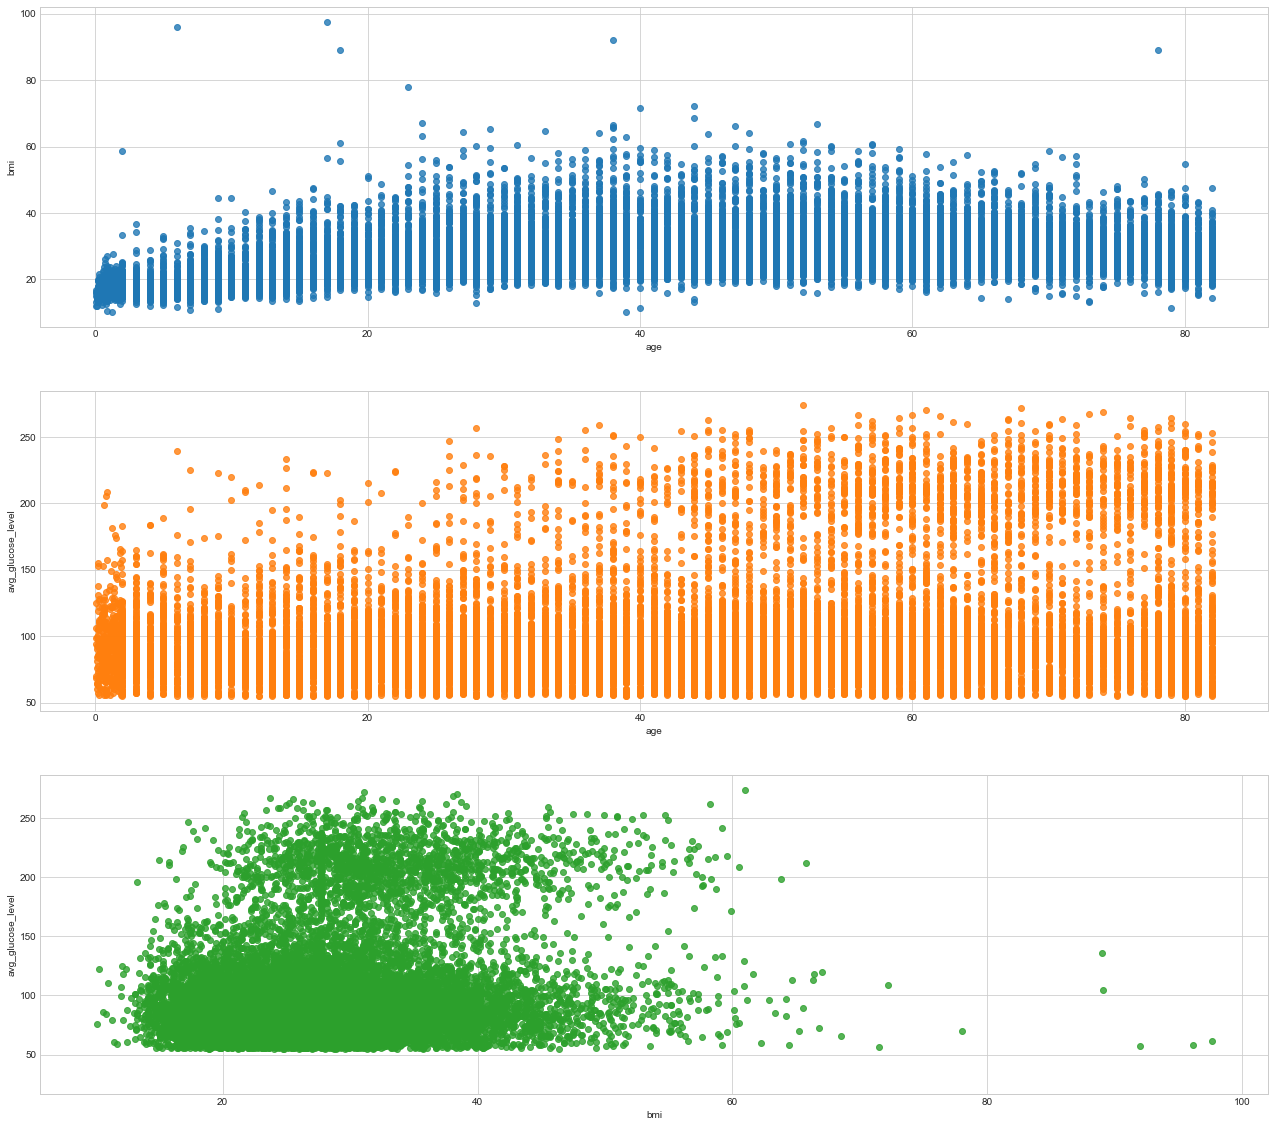

In [681]:
# Bivariate Analysis - Relation between numerical variables

fig, axs = plt.subplots(3, figsize = (22,20), clear = True)

ax = sns.regplot(x= 'age', y = 'bmi', data = train, fit_reg = False, ax = axs[0])
ax = sns.regplot(x= 'age', y = 'avg_glucose_level', data = train, fit_reg = False, ax = axs[1])
ax = sns.regplot(x= 'bmi', y = 'avg_glucose_level', data = train, fit_reg = False, ax = axs[2])

In [689]:
# Creating classification models; clf - with all features; estimator - with selected features
clf = GradientBoostingClassifier(random_state=0, max_depth = 5,  max_leaf_nodes = 90)
estimator = GradientBoostingClassifier(random_state=0, max_depth = 5,  max_leaf_nodes = 90)

# Other Attempts
#clf = DecisionTreeClassifier(random_state=0, max_depth = 5,  max_leaf_nodes = 90)
#clf = AdaBoostClassifier(random_state=0, n_estimators=10, learning_rate=0.5)
#clf = LogisticRegression(random_state=0, max_iter = 150, solver = 'lbfgs')
#estimator = LogisticRegression(random_state=0, max_iter = 150, solver = 'lbfgs')
#clf = SVC(random_state=0, max_iter = 125, probability = True)
#estimator = SVC(random_state=0, max_iter = 125, probability = True)

In [690]:
# For Train: Generating Dummy Variables and dropping one extra for each category; Drop redundant variables
X_train_with_dummies = pd.get_dummies(X_train)
X_train_with_dummies.drop(['id','Residence_type_Rural','Residence_type_Urban','bmi','avg_glucose_level', 'gender_Female', 'gender_Other', 'hypertension_0', 'heart_disease_0','ever_married_No', 'work_type_Govt_job'], axis =1, inplace =True)
X_train_with_dummies.head()
X_train_with_dummies.columns

# Other Attempts to drop/understand variables
#X_train_with_dummies.drop(['id','Residence_type_Rural','Residence_type_Urban','bmi','avg_glucose_level', 'gender_Female','hypertension_0', 'heart_disease_0','ever_married_No', 'work_type_Govt_job', 'gender_Male', 'gender_Other'], axis =1, inplace =True)
#X_train_with_dummies.drop(['id','bmi','avg_glucose_level', 'gender_Female','hypertension_0', 'heart_disease_0','ever_married_No', 'work_type_Govt_job'], axis =1, inplace =True)

Index(['age', 'log_bmi', 'log_avg_glucose_level', 'gender_Male',
       'hypertension_1', 'heart_disease_1', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [691]:
# Cross Validating Score with Training Data
cross_val_score(clf, X_train_with_dummies, y_train.stroke, cv=10)

array([ 0.95572917,  0.95225694,  0.95138889,  0.953125  ,  0.94874023,
        0.94700261,  0.95478261,  0.94869565,  0.94869565,  0.95130435])

In [692]:
# Training Classifier
clf.fit(X_train_with_dummies, y_train.stroke)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=90,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [694]:
# For Test: Generating Dummy Variables and dropping one extra for each category; Drop redundant variables
X_test_with_dummies = pd.get_dummies(X_test)
X_test_with_dummies.drop(['id','Residence_type_Rural','Residence_type_Urban','bmi','avg_glucose_level', 'gender_Female', 'hypertension_0', 'heart_disease_0','ever_married_No', 'work_type_Govt_job'], axis =1, inplace =True)
X_test_with_dummies.columns

# Other Attempts to drop/understand variables
#X_test_with_dummies.drop(['id','Residence_type_Rural','Residence_type_Urban','bmi','avg_glucose_level', 'gender_Female','hypertension_0', 'heart_disease_0','ever_married_No', 'work_type_Govt_job', 'gender_Male'], axis =1, inplace =True)
#X_test_with_dummies.drop(['id','bmi','avg_glucose_level', 'gender_Female','hypertension_0', 'heart_disease_0','ever_married_No', 'work_type_Govt_job'], axis =1, inplace =True)

Index(['age', 'log_bmi', 'log_avg_glucose_level', 'gender_Male',
       'hypertension_1', 'heart_disease_1', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [695]:
# Calculate Score on our Test Set
clf.score(X_train_with_dummies, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test_with_dummies)[:,1])

0.85482667968530546

In [696]:
# Step-wise Elimination to select best features
selector = RFE(estimator, 8, step=1)
selector = selector.fit(X_train_with_dummies, y_train.stroke)
selector.support_ 
selector.ranking_

X_train_with_dummies.columns[selector.support_]

# Other Attempts
#estimator = DecisionTreeClassifier(random_state=0, max_depth =5, max_leaf_nodes = 90)
#estimator = AdaBoostClassifier(random_state=0, n_estimators=50, learning_rate=0.3)
#estimator = GradientBoostingClassifier(random_state=0, max_depth = 5,  max_leaf_nodes = 90)
#estimator = LogisticRegression(random_state=0)

Index(['age', 'log_bmi', 'log_avg_glucose_level', 'gender_Male',
       'hypertension_1', 'heart_disease_1', 'smoking_status_formerly smoked',
       'smoking_status_never smoked'],
      dtype='object')

In [697]:
# Filter the selected features
X_train_with_dummies_selected = X_train_with_dummies[X_train_with_dummies.columns[selector.support_]]
X_test_with_dummies_selected = X_test_with_dummies[X_test_with_dummies.columns[selector.support_]]

In [698]:
# Cross Validation Score on Training Set
cross_val_score(clf, X_train_with_dummies_selected, y_train.stroke, cv=20)

array([ 0.95147314,  0.95667244,  0.95493934,  0.94454073,  0.94791667,
        0.94791667,  0.96      ,  0.95304348,  0.94782609,  0.94956522,
        0.95652174,  0.94608696,  0.94782609,  0.95478261,  0.94956522,
        0.95478261,  0.94782609,  0.95652174,  0.94608696,  0.95304348])

In [699]:
# Training Classifier on Selected Features
estimator.fit(X_train_with_dummies_selected, y_train.stroke)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=90,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [700]:
# Calculate Score with Selected Features
estimator.score(X_train_with_dummies_selected, y_train)
roc_auc_score(y_test, estimator.predict_proba(X_test_with_dummies_selected)[:,1])

0.85010597016949419

In [701]:
# Predicting result on the given test set;
test = test_data.copy()

# Pre-processing
test.bmi.fillna(test.bmi.median(), inplace = True)
test.hypertension = test.hypertension.astype('category')
test.heart_disease = test.heart_disease.astype('category')
test['log_bmi'] = np.log10(test.bmi)
test['log_avg_glucose_level'] = np.log10(test.avg_glucose_level)

# BoxCox didn't work well
#test['log_bmi'] = scipy.stats.boxcox(test.bmi, lmbda=None)[0]
#test['log_avg_glucose_level'] = scipy.stats.boxcox(test.avg_glucose_level, lmbda=None)[0]

# Dummies and Feature Selection
test_with_dummies = pd.get_dummies(test)
test_with_dummies.drop(['id','Residence_type_Rural','Residence_type_Urban','bmi','avg_glucose_level', 'gender_Female', 'gender_Other', 'hypertension_0', 'heart_disease_0','ever_married_No', 'work_type_Govt_job'], axis =1, inplace =True)
test_with_dummies_selected = test_with_dummies[test_with_dummies.columns[selector.support_]]
test_with_dummies_selected.columns

Index(['age', 'log_bmi', 'log_avg_glucose_level', 'gender_Male',
       'hypertension_1', 'heart_disease_1', 'smoking_status_formerly smoked',
       'smoking_status_never smoked'],
      dtype='object')

In [702]:
result = pd.DataFrame()
result["stroke"] = estimator.predict_proba(test_with_dummies_selected)[:,1]
result["id"] = test.id

In [703]:
result[["id", "stroke"]].to_csv("/Users/divyavakil/Documents/GradientBoostDecisionTree.csv", index=False)